# Import

In [1]:
from google.colab import drive
drive.mount('/gdrive')
%cd /gdrive/My Drive/ANN Competition/Homework2/davide

Mounted at /gdrive
/gdrive/.shortcut-targets-by-id/1ckveNGqgPJLZP8oVcHRvQStV1LtkEwq1/ANN Competition/Homework2/davide


In [2]:
# Fix randomness and hide warnings
seed = 42

import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'
os.environ['PYTHONHASHSEED'] = str(seed)
os.environ['MPLCONFIGDIR'] = os.getcwd()+'/configs/'

import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
warnings.simplefilter(action='ignore', category=Warning)

import numpy as np
from math import sqrt
np.random.seed(seed)

import logging

import random
random.seed(seed)

In [3]:
# Import tensorflow
import tensorflow as tf
from tensorflow import keras as tfk
from tensorflow.keras import layers as tfkl
import keras.backend as K

tf.autograph.set_verbosity(0)
tf.get_logger().setLevel(logging.ERROR)
tf.compat.v1.logging.set_verbosity(tf.compat.v1.logging.ERROR)
tf.random.set_seed(seed)
tf.compat.v1.set_random_seed(seed)
print(tf.__version__)

2.15.0


In [4]:
import pandas as pd
import seaborn as sns
from datetime import datetime
import matplotlib.pyplot as plt
from pandas.plotting import autocorrelation_plot
from statsmodels.graphics.tsaplots import plot_acf
from statsmodels.tsa.stattools import acf, pacf
plt.rc('font', size=16)
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from sklearn.utils import shuffle
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score
from sklearn.metrics import confusion_matrix
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error


from statsmodels.tsa.seasonal import seasonal_decompose
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import IsolationForest

# Data Inspection


In [5]:
import zipfile

dataset = np.load('dataset/training_data.npy', allow_pickle=False)
categories = np.load('dataset/categories.npy', allow_pickle=False)
valid_periods = np.load('dataset/valid_periods.npy', allow_pickle=False)

dataset_df = pd.DataFrame(dataset)
categories_df = pd.DataFrame(categories)
valid_periods_df = pd.DataFrame(valid_periods)

print('dataset size:',str(dataset_df.shape) , '\nCategories size:', str(categories_df.shape) ,'\nvalid_periods size:', str(valid_periods_df.shape))


dataset size: (48000, 2776) 
Categories size: (48000, 1) 
valid_periods size: (48000, 2)


In [6]:
print('Dataset info:\n')
dataset_df.info()
print('\n-------------------------------------\n')
print('Categories info:\n')
categories_df.info()

Dataset info:

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 48000 entries, 0 to 47999
Columns: 2776 entries, 0 to 2775
dtypes: float64(2776)
memory usage: 1016.6 MB

-------------------------------------

Categories info:

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 48000 entries, 0 to 47999
Data columns (total 1 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   0       48000 non-null  object
dtypes: object(1)
memory usage: 375.1+ KB


In [7]:
dataset_df = dataset_df.astype(np.float32)
dataset_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 48000 entries, 0 to 47999
Columns: 2776 entries, 0 to 2775
dtypes: float32(2776)
memory usage: 508.3 MB


# Data Inspection - Plots
- work on new_dataset_transp_df in order to have the timestamps as row of the dataframe

In [8]:
dataset_df['category'] = categories_df
dataset_plot = dataset_df.T
mapping = {
    'A': 0,
    'B': 1,
    'C': 2,
    'D': 3,
    'E': 4,
    'F': 5
}
dataset_plot.loc['category'] = dataset_plot.loc['category'].map(mapping)

dataset_plot

,0,1,2,3,4,5,6,7,8,9,...,47990,47991,47992,47993,47994,47995,47996,47997,47998,47999
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2772,0.516667,0.536,0.955206,0.450502,0.863636,0.653061,0.878788,0.8625,0.130258,0.098921,...,0.072276,0.824082,0.701938,0.589687,0.807554,0.447455,0.504665,0.625,0.445596,0.588415
2773,0.602778,0.6,0.960481,0.470588,0.727273,0.653061,0.841492,0.8625,0.12483,0.098022,...,0.071384,0.898371,0.78355,0.602126,0.882692,0.454175,0.504545,0.526316,0.445596,0.542683
2774,0.367593,0.46,0.946506,0.569584,0.818182,0.632653,0.841492,0.87625,0.132972,0.091727,...,0.071545,0.048314,0.808614,0.611088,0.051239,0.623485,0.52176,0.582237,0.585492,0.609756
2775,0.331481,0.396,0.97714,0.571019,0.840909,0.642857,0.834499,0.895,0.104478,0.095324,...,0.081005,0.129289,0.893487,0.681044,0.132994,0.013329,0.091133,0.552632,0.404145,0.591463


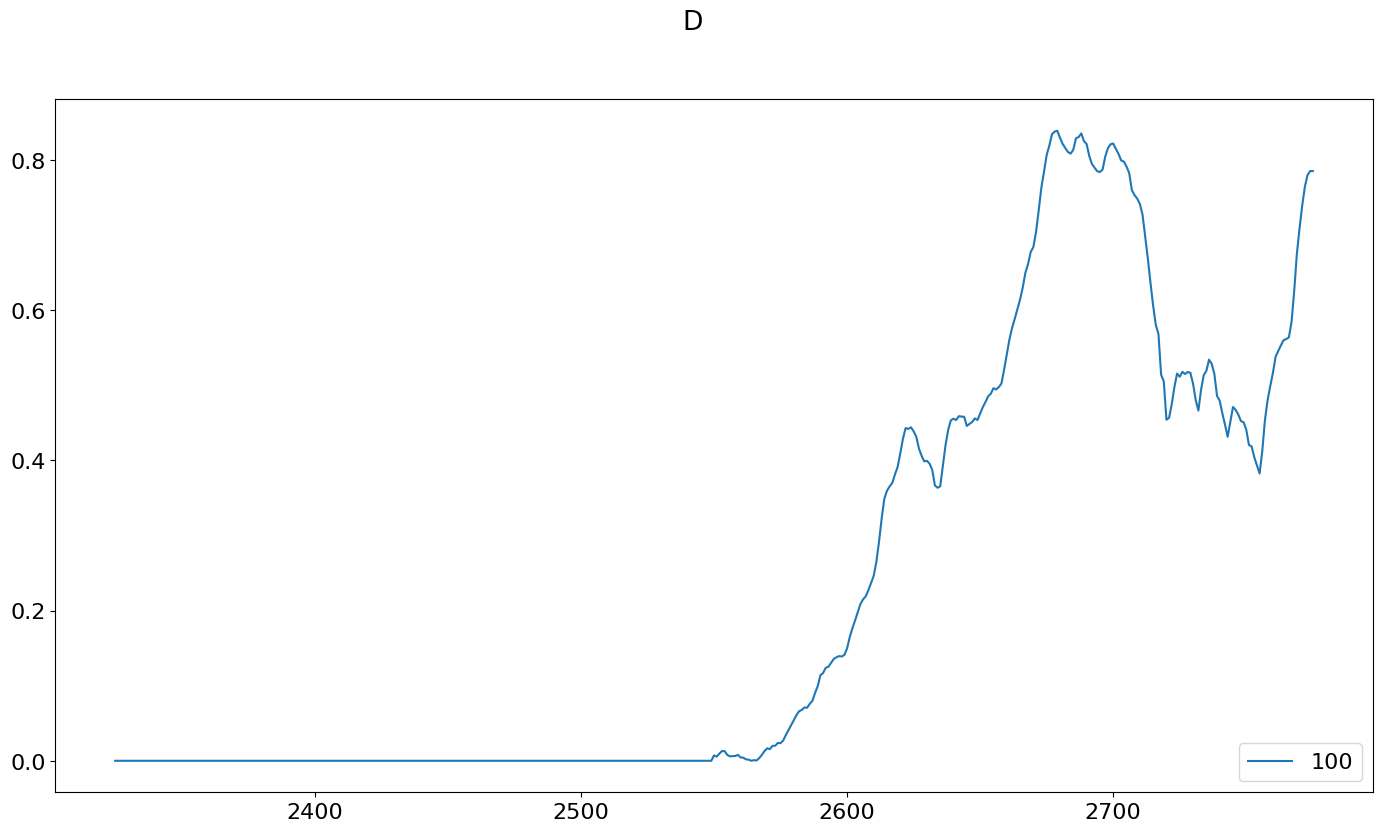

In [9]:
# plot TimeSeries with corresponding category

def inspect_category(index,df):
    data = df.iloc[valid_periods_df[0][0]:-1,index] # extract only valid periods
    axis = data.plot(subplots=True, figsize=(17, 9), title=categories_df[0][index])
    for ax in axis:
        ax.legend(loc='lower right')

inspect_category(100,dataset_plot) # index corresponds to the i_th time series in the dataframe

Inspection by category

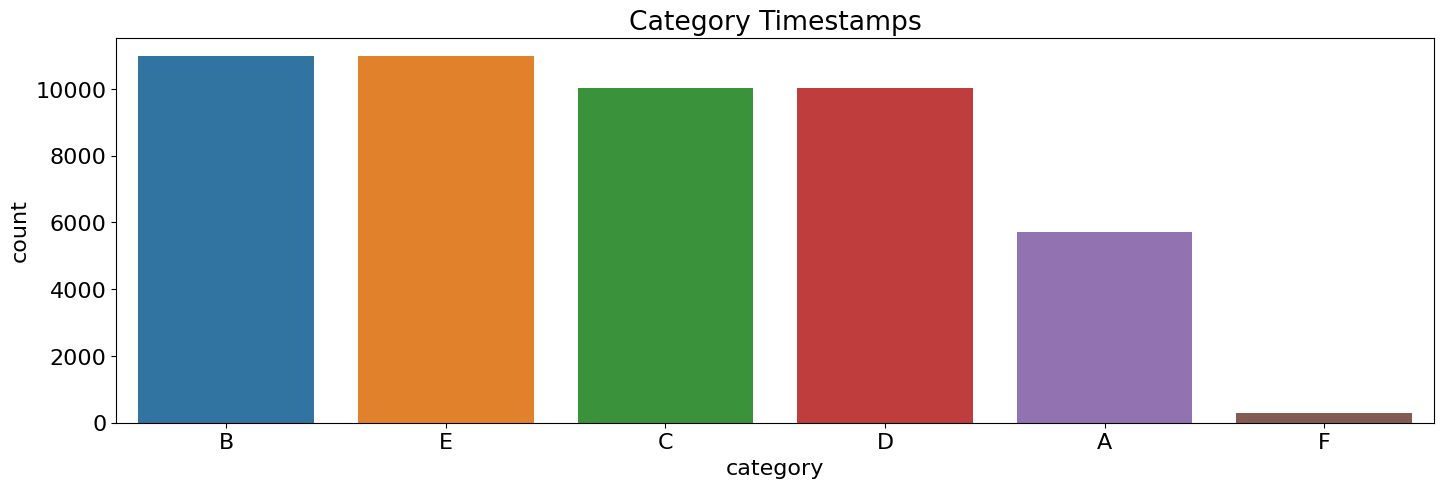

In [10]:
# Inspect activities timestamps
plt.figure(figsize=(17,5))
sns.countplot(x = 'category', data = dataset_df, order = dataset_df.category.value_counts().index)
plt.title('Category Timestamps')
plt.show()

In [11]:
dataset_df.category.value_counts()

B    10987
E    10975
C    10017
D    10016
A     5728
F      277
Name: category, dtype: int64

Trend analysis

In [12]:
index = 100
TS = dataset_plot.iloc[valid_periods_df[0][0]:-1,index].copy()
TS = pd.DataFrame(TS)
TS = TS.rename(columns={200: 'data'})

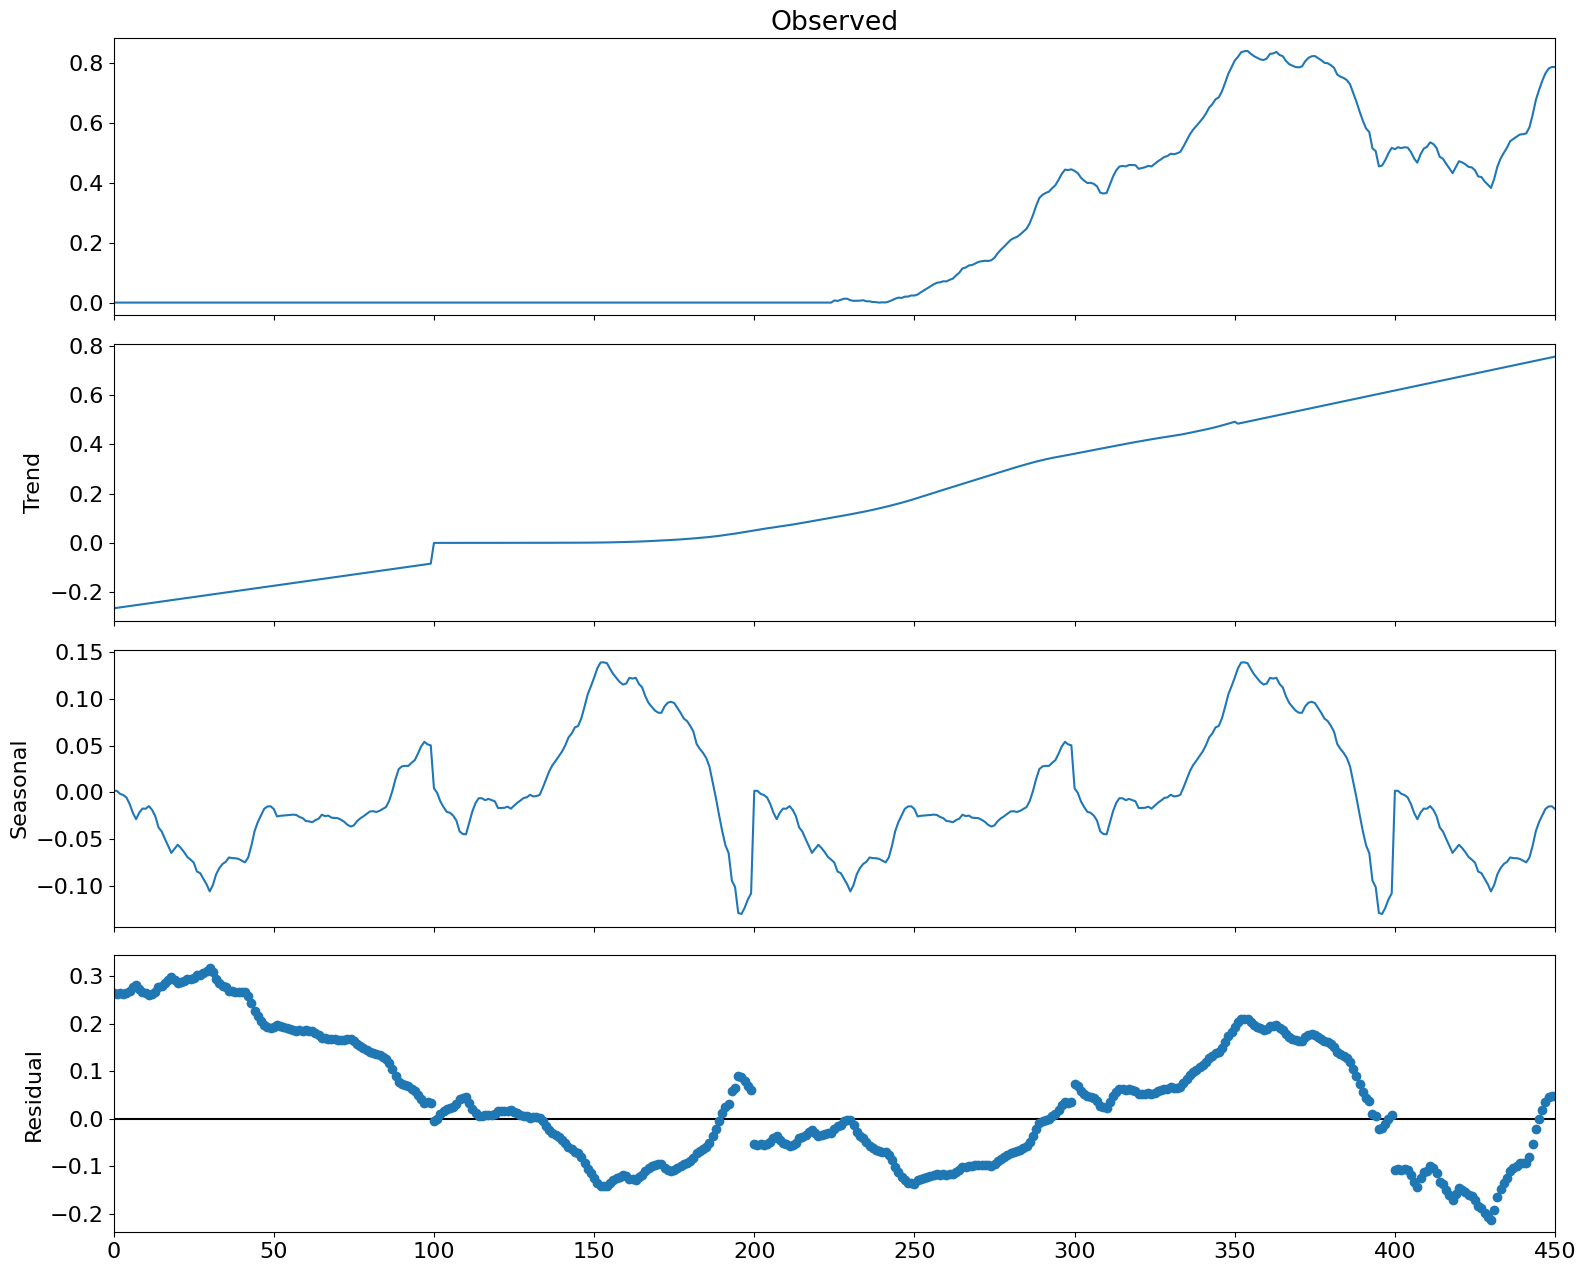

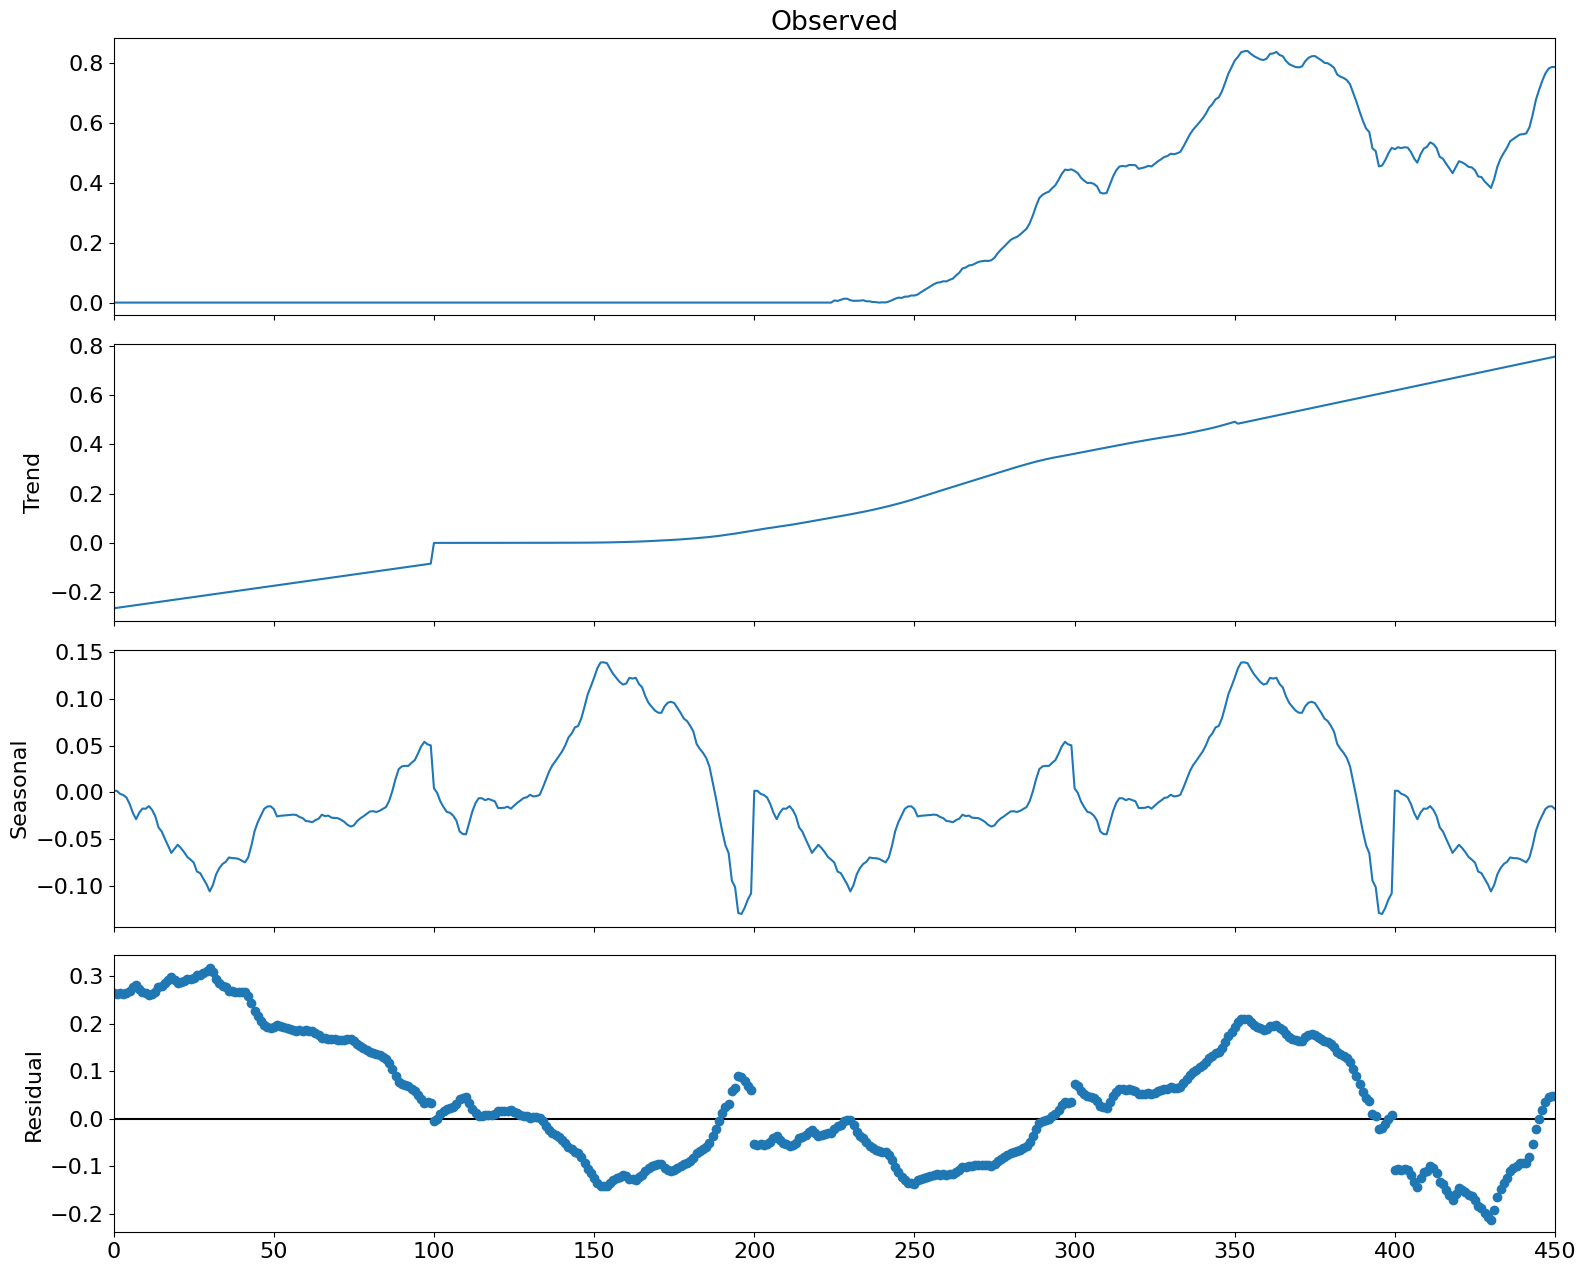

In [13]:
RES = seasonal_decompose(TS.values, model='additive', extrapolate_trend='freq', period=200)
plt.rcParams.update({'figure.figsize':(16,13)})
RES.plot()

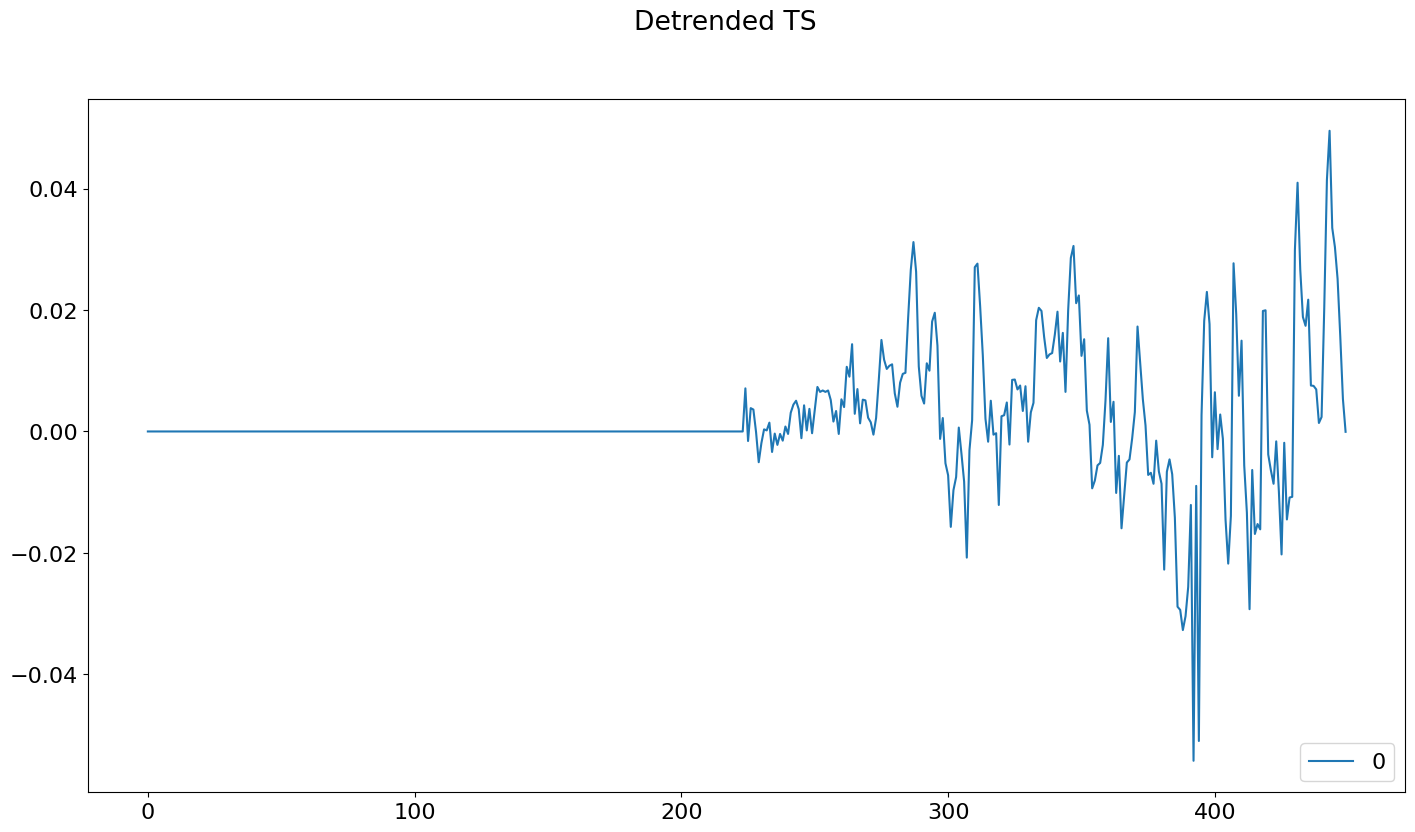

In [14]:
# Apply detrending, normalizing time series

X = TS.values
diff = list()
for i in range(1, len(X)):
 value = X[i] - X[i - 1]
 diff.append(value)
#plt.plot(diff)
diff = pd.DataFrame(diff)
axis = diff.plot(subplots=True, figsize=(17, 9), title='Detrended TS')
for ax in axis:
    ax.legend(loc='lower right')
#plt.show()

Autocorrelation analysis

In [15]:
dataset_A = dataset_plot.iloc[:-1, np.array([dataset_plot.loc['category'] == 0])[0]]
dataset_B = dataset_plot.iloc[:-1, np.array([dataset_plot.loc['category'] == 1])[0]]
dataset_C = dataset_plot.iloc[:-1, np.array([dataset_plot.loc['category'] == 2])[0]]
dataset_D = dataset_plot.iloc[:-1, np.array([dataset_plot.loc['category'] == 3])[0]]
dataset_E = dataset_plot.iloc[:-1, np.array([dataset_plot.loc['category'] == 4])[0]]
dataset_F = dataset_plot.iloc[:-1, np.array([dataset_plot.loc['category'] == 5])[0]]

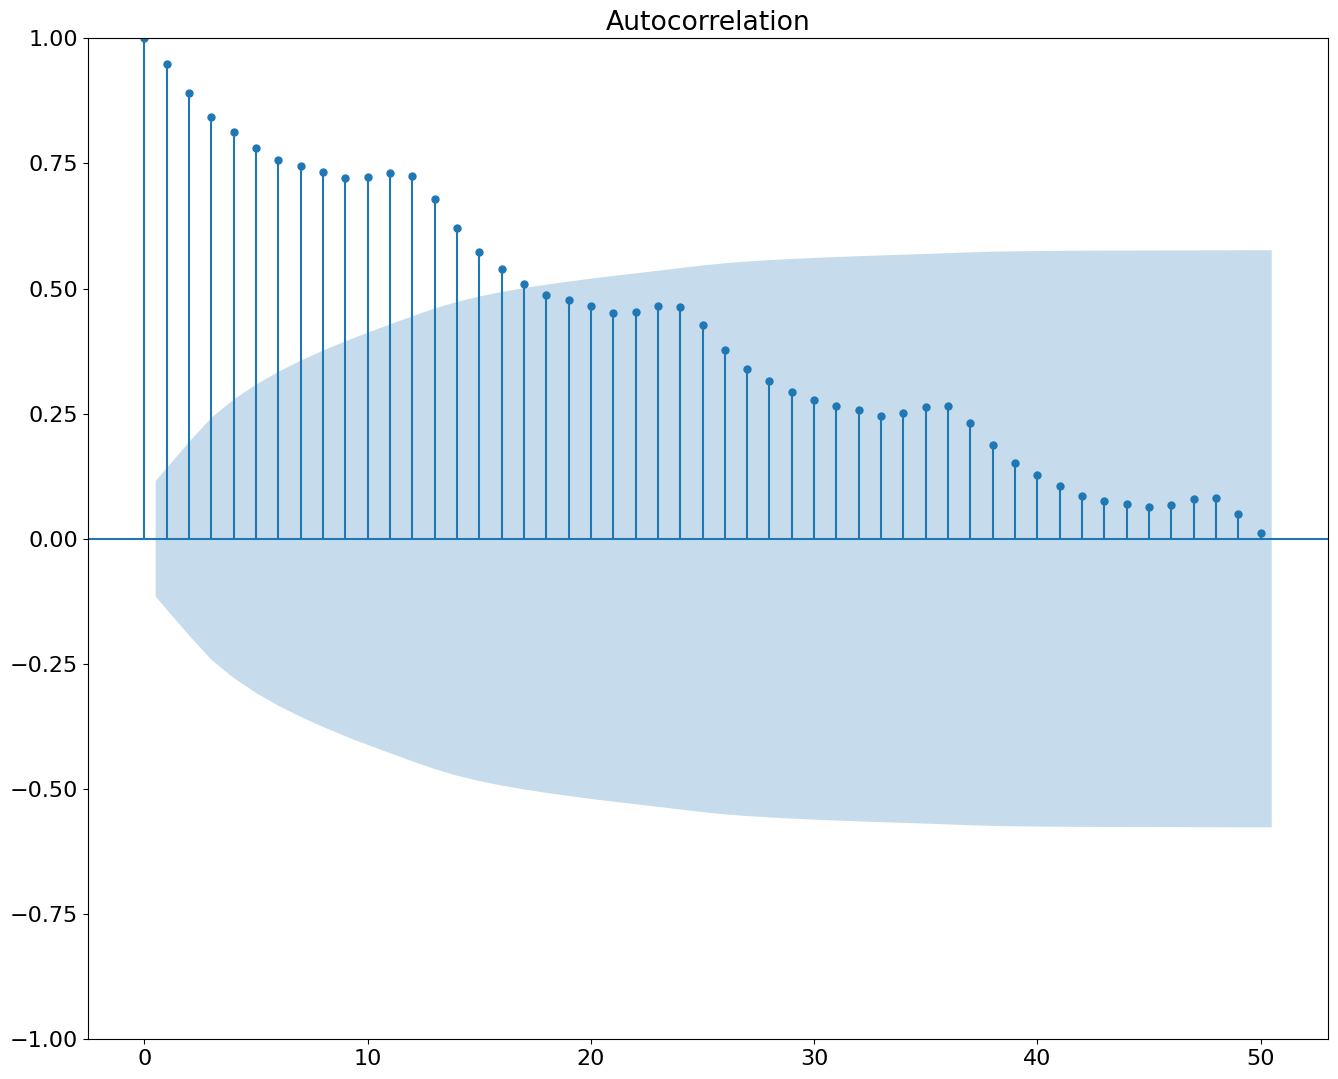

In [16]:
plot_acf(dataset_A[dataset_A.columns[2000]][valid_periods_df[0][dataset_A.columns[2000]]:], lags=50, alpha=.05)
plt.show()

<BarContainer object of 50 artists>

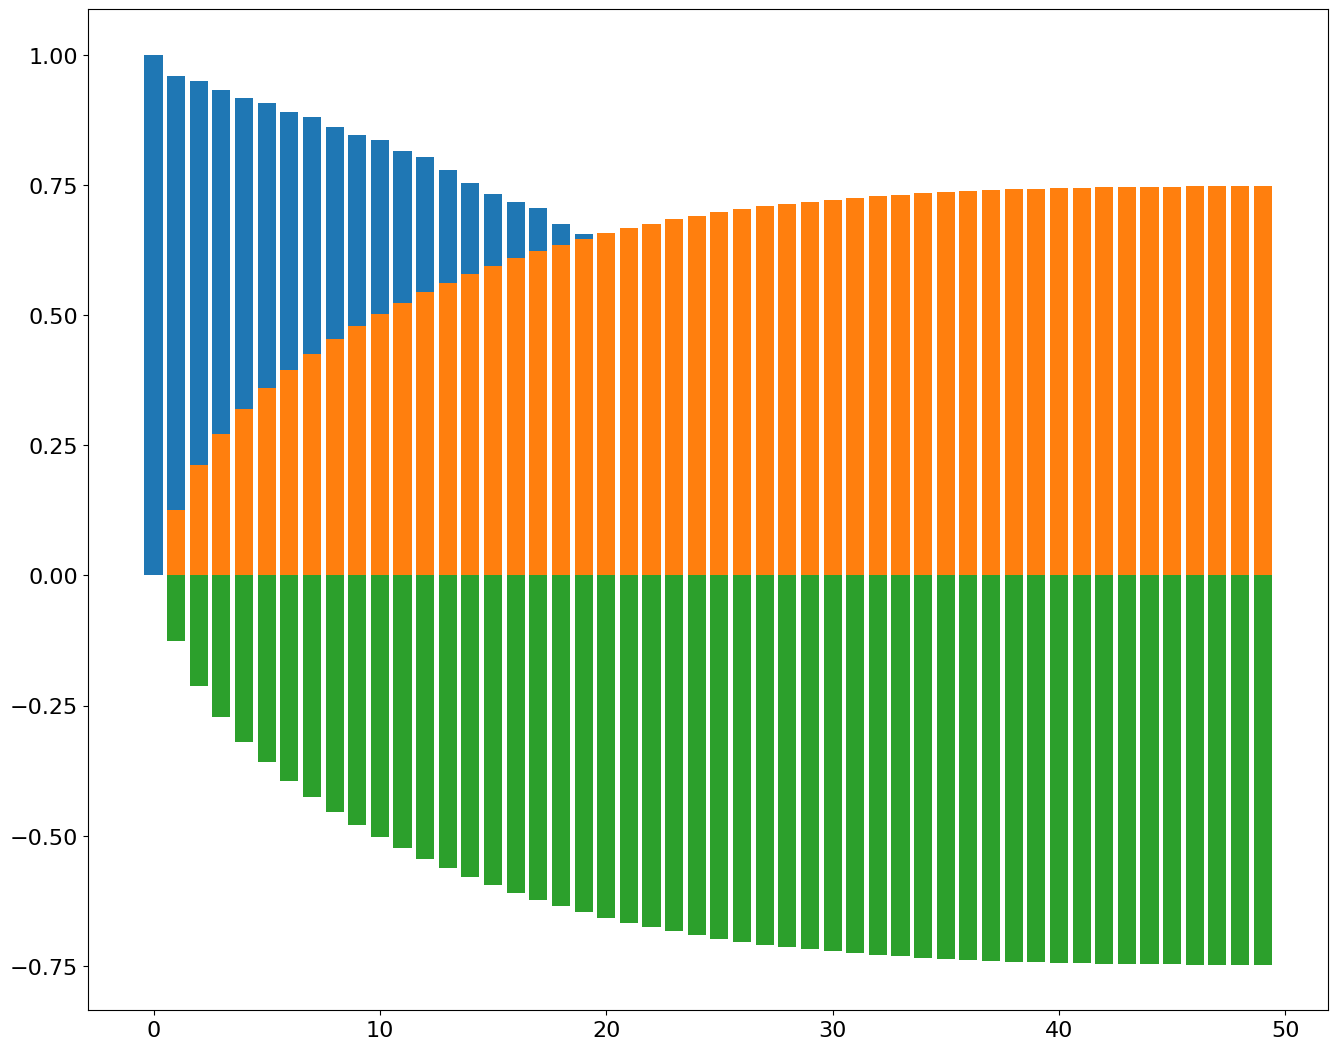

In [17]:
acf_values, confi_values = acf(dataset_A[dataset_A.columns[0]][valid_periods_df[0][dataset_A.columns[0]]:],
                               nlags=len(dataset_A[dataset_A.columns[0]][valid_periods_df[0][dataset_A.columns[0]]:]), alpha=.05)
num_lags = 50
plt.bar(range(num_lags), acf_values[:num_lags])
plt.bar(range(num_lags), (confi_values[:num_lags, 1] - acf_values[:num_lags]))
plt.bar(range(num_lags), (confi_values[:num_lags, 0] - acf_values[:num_lags]))

In [18]:
def get_window_value(df, column, significance=0.95):

  temp_df = df[valid_periods_df[0][column]:]
  acf_values, confi_values = acf(temp_df, nlags=len(temp_df), alpha=1-significance)

  intersect = confi_values[:, 1] - acf_values[:]

  window = np.where([acf_values <= intersect])

  if len(window[1]) == 0:
    print(temp_df)
    print(intersect)
    print(acf_values)

  return window[1][0]

In [19]:
def get_window_size(df, significance=0.95):

  windows = []

  for i in range(len(df.columns)):

    window = get_window_value(df[df.columns[i]], df.columns[i], significance=significance)
    # Estimate window size based on the first significant lag
    if window > 0:
        estimated_window_size = window
        windows.append(estimated_window_size)
        #print(f"Estimated Window Size: {estimated_window_size}")
    else:
        print("No significant lag found. Adjust the threshold.")

  return int(np.array(windows).mean())

In [20]:
print(get_window_size(dataset_D, significance=.95))

16


# Time series preprocessing

In [21]:
# Time series extraction without padding
valid_TS = []
for i in range(dataset.shape[0]):
  signal = dataset[i]
  valid = valid_periods[i]
  valid_signal = signal[valid_periods[i][0]:valid_periods[i][1]]
  valid_TS.append(valid_signal)


In [22]:
X_train_raw, X_test_raw = train_test_split(
    valid_TS,
    test_size = 0.08,
    stratify=categories,
    random_state = seed
)
len(X_train_raw),len(X_test_raw)

(44160, 3840)

In [23]:
window = 200
stride = 5
direct_telescope = 9

In [24]:
def build_sequences(df, window, stride, telescope):
    # Sanity check to avoid runtime errors
    assert window % stride == 0
    dataset = []
    labels = []
    temp_df = df.copy()


    for i in range(len(df)): # build sequences for each time series (considering only valid periods)

        if(len(temp_df[i]) <= window): # handle time series shorter or equal than the window
          padding_check = len(df[i])%window

          if(padding_check != 0):
              # Compute padding length
              padding_len = window - len(temp_df[i])%window
              padding = np.zeros((padding_len), dtype='float32')
              temp_df[i] = np.concatenate((padding, temp_df[i]), axis=0)
              assert len(temp_df[i]) % window == 0

          padding_len = telescope
          padding = np.zeros((padding_len), dtype='float32')
          temp_df[i] = np.concatenate((padding, temp_df[i]), axis = 0)
          dataset.append(temp_df[i][0:window])
          labels.append(temp_df[i][window:window+telescope])

        # Checks whether the time series is a multiple of the stride,
        # in such a way as to minimize the number of zeros used for padding.

        else:
          padding_check = len(df[i])%stride

          if(padding_check != 0):
              # Compute padding length
              padding_len = stride - len(temp_df[i])%stride
              padding = np.zeros((padding_len), dtype='float32')
              temp_df[i] = np.concatenate((padding, temp_df[i]), axis=0)
              assert len(temp_df[i]) % stride == 0

          padding = np.zeros((telescope), dtype='float32')
          temp_df[i] = np.concatenate((padding, temp_df[i]), axis=0)

          # Build sequences for each time series balanced with padding.

          for idx in np.arange(0,len(temp_df[i])-window-telescope+1,stride):
             dataset.append(temp_df[i][idx:idx+window])
             labels.append(temp_df[i][idx+window:idx+window+telescope])

    dataset = np.array(dataset)
    labels = np.array(labels)
    return dataset, labels

In [25]:
X_train, y_train = build_sequences(X_train_raw,window,stride,direct_telescope)
X_test, y_test =  build_sequences(X_test_raw,window,stride,direct_telescope)
input_shape = (200,1)
output_shape = (9,1)
X_train.shape, y_train.shape, X_test.shape, y_test.shape

((516158, 200), (516158, 9), (46149, 200), (46149, 9))

# Building Model

In [26]:
# create custom attention model following the slides
def build_model(input_shape, output1_shape):
  input = tfkl.Input(shape=input_shape)

  C = tfkl.Bidirectional(tfkl.GRU(32, return_sequences=True))(input)
  C = tfkl.Bidirectional(tfkl.GRU(32, return_sequences=True))(C)
  C = tfkl.Conv1D(64, 15, padding='same', activation='relu')(C)
  C = tfkl.Dropout(0.4)(C)
  C = tfkl.Flatten()(C)

  output = tfkl.Dense(output1_shape[0], activation='relu')(C)


  model = tf.keras.Model(inputs=input, outputs=output, name='GRU')
  model.compile(loss='mse',optimizer=tf.keras.optimizers.Adam())

  return model


  ## 0.0047 in submission

Model: "GRU"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 200, 1)]          0         
                                                                 
 bidirectional (Bidirection  (None, 200, 64)           6720      
 al)                                                             
                                                                 
 bidirectional_1 (Bidirecti  (None, 200, 64)           18816     
 onal)                                                           
                                                                 
 conv1d (Conv1D)             (None, 200, 64)           36928     
                                                                 
 dropout (Dropout)           (None, 200, 64)           0         
                                                                 
 flatten (Flatten)           (None, 12800)             0       

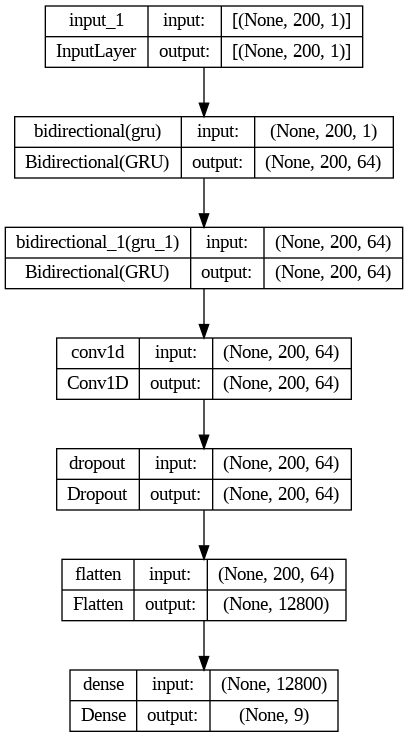

In [27]:
model = build_model(input_shape, output_shape)
# Compile the model with Mean Squared Error loss and Adam optimizer
model.compile(loss=tf.keras.losses.MeanSquaredError(), optimizer=tf.keras.optimizers.Adam())
model.summary()
tfk.utils.plot_model(model, expand_nested=True, show_shapes=True)

In [ ]:
logdir = os.path.join("logs", datetime.now().strftime("%Y%m%d-%H%M%S"))

callbacks = [
    tfk.callbacks.EarlyStopping(monitor='val_loss',patience=18, restore_best_weights=True, mode='auto'),
    tfk.callbacks.ReduceLROnPlateau(monitor="val_loss", patience=10, factor=0.1, min_lr=1e-5),
    #TensorBoard(logdir, histogram_freq=1)
]

#%tensorboard --logdir logs

# Train the model
history = model.fit(
    x = X_train,
    y = y_train,
    batch_size = 128,
    epochs = 130,
    validation_split = 0.1,
    callbacks = callbacks
).history

In [ ]:
model.save('models/final_model')
del model

In [ ]:
model = tf.keras.models.load_model('models/final_model')

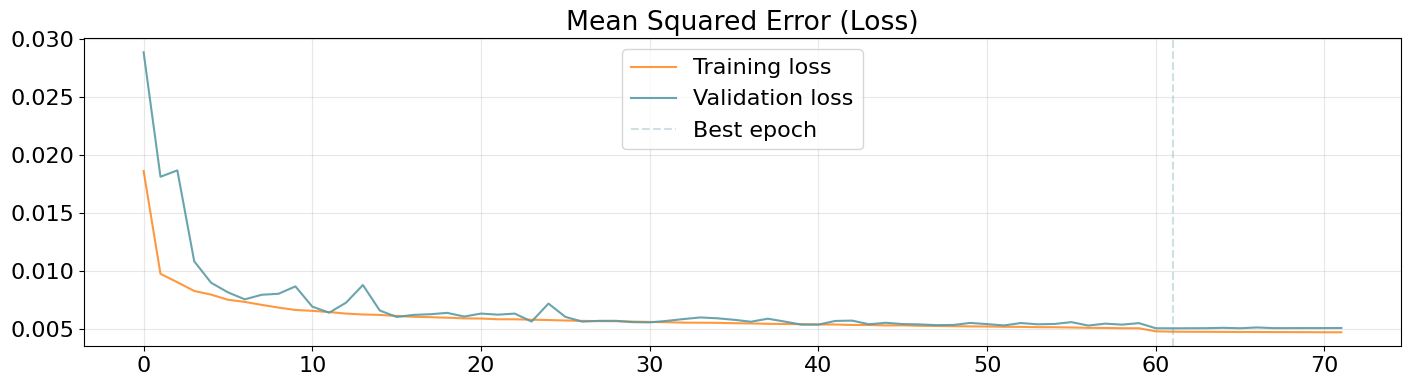

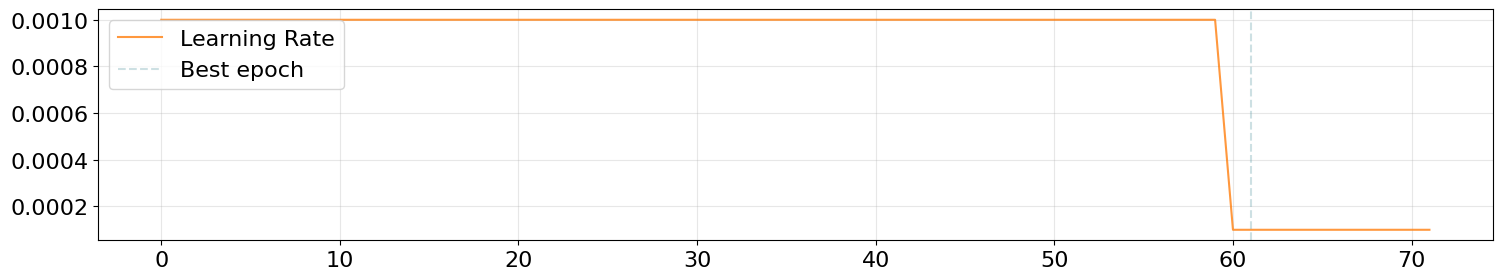

In [ ]:
best_epoch = np.argmin(history['val_loss'])
plt.figure(figsize=(17,4))
plt.plot(history['loss'], label='Training loss', alpha=.8, color='#ff7f0e')
plt.plot(history['val_loss'], label='Validation loss', alpha=.9, color='#5a9aa5')
plt.axvline(x=best_epoch, label='Best epoch', alpha=.3, ls='--', color='#5a9aa5')
plt.title('Mean Squared Error (Loss)')
plt.legend()
plt.grid(alpha=.3)
plt.show()

plt.figure(figsize=(18,3))
plt.plot(history['lr'], label='Learning Rate', alpha=.8, color='#ff7f0e')
plt.axvline(x=best_epoch, label='Best epoch', alpha=.3, ls='--', color='#5a9aa5')
plt.legend()
plt.grid(alpha=.3)
plt.show()

In [ ]:
# Predict the test set using the model
predictions = model.predict(X_test, verbose=0)

# Print the shape of the predictions
print(f"Predictions shape: {predictions.shape}")

# Calculate and print Mean Squared Error (MSE)
mean_squared_error = tfk.metrics.mean_squared_error(y_test.flatten(), predictions.flatten()).numpy()
print(f"Mean Squared Error: {mean_squared_error}")

# Calculate and print Mean Absolute Error (MAE)
mean_absolute_error = tfk.metrics.mean_absolute_error(y_test.flatten(), predictions.flatten()).numpy()
print(f"Mean Absolute Error: {mean_absolute_error}")

Predictions shape: (36463, 9)
Mean Squared Error: 0.005130982957780361
Mean Absolute Error: 0.04505688324570656


# Composite Prediction (Autoregression Forecasting)

In [ ]:
model = tfk.models.load_model('Models//Maximus Prime')

In [ ]:
def predict(input):
  input = tf.reshape(input, (-1, input.shape[0], 1))
  prediction = []
  # first 9 forecasted values
  prediction.append(model.predict(input))

  # we kept the cycle form, even if not necessary, to try models that forecasted only 1 value, 2 values, etc..
  for i in range(1, 2):
    #take the last 191 steps of the input
    I = tf.cast(input[:, i*9:, :], tf.float32)
    predsofar = tf.cast(prediction, tf.float32)
    predsofar = tf.reshape(predsofar, (-1, 9, 1))

    #concatenate the 191 time steps with our 9 predicted time steps
    I = tf.concat([I, predsofar], axis=1)

    #predict the next 9 time steps
    prediction.append(model.predict(I))

  return tf.cast(tf.reshape(prediction, (18)), tf.float64)

In [ ]:
print(X_test.shape)
predictions = tf.map_fn(predict, X_test[:5000])

print(tf.reduce_mean(tf.square(y_test[:5000]-predictions), axis=(0, 1)))

Output streaming troncato alle ultime 5000 righe.
1/1 [==============================] - 0s 33ms/step
tf.Tensor(0.008845448766645126, shape=(), dtype=float64)


# Attention Experiment

In [ ]:
# create custom attention model following the slides
def build_model(input_shape, output1_shape):
  input = tfkl.Input(shape=input_shape)


  encoder = tfkl.GRU(64, return_sequences=True)(input)
  decoder = tfkl.GRU(64)(encoder)

  context = tfkl.Attention()([decoder, encoder])
  C = tfkl.Concatenate()([decoder, context[:,0,:]])

  output = tfkl.Dense(9, activation='sigmoid')(C)


  model = tf.keras.Model(inputs=input, outputs=output, name='GRU_ATT_V1')
  model.compile(loss='mse',
                optimizer=tf.keras.optimizers.Adam())

  return model

# Transformer Experiment

In [ ]:
def transformer_encoder(inputs, head_size, num_heads, ff_dim, dropout=0):
    # Normalization and Attention
    x = tfkl.LayerNormalization(epsilon=1e-6)(inputs)
    x = tfkl.MultiHeadAttention(
        key_dim=head_size, num_heads=num_heads, dropout=dropout
    )(x, x)
    x = tfkl.Dropout(dropout)(x)
    res = x + inputs

    # Feed Forward Part
    x = tfkl.LayerNormalization(epsilon=1e-6)(res)
    x = tfkl.Conv1D(filters=ff_dim, kernel_size=1, activation="relu")(x)
    x = tfkl.Dropout(dropout)(x)
    x = tfkl.Conv1D(filters=inputs.shape[-1], kernel_size=1)(x)
    return x + res

In [ ]:
def build_model(
    input_shape,
    head_size,
    num_heads,
    ff_dim,
    num_transformer_blocks,
    mlp_units,
    dropout=0,
    mlp_dropout=0,
):
    inputs = tfkl.Input(shape=input_shape)
    x = inputs
    for _ in range(num_transformer_blocks):
        x = transformer_encoder(x, head_size, num_heads, ff_dim, dropout)

    x = tfkl.GlobalAveragePooling1D(data_format="channels_first")(x)
    for dim in mlp_units:
        x = tfkl.Dense(dim, activation="relu")(x)
        x = tfkl.Dropout(mlp_dropout)(x)
    outputs = tfkl.Dense(9)(x)
    return tfk.Model(inputs, outputs)

In [ ]:

model = build_model(
    (200, 1),
    head_size=100,
    num_heads=4,
    ff_dim=4,
    num_transformer_blocks=2,
    mlp_units=[64],
    mlp_dropout=0.4,
    dropout=0.25,
)

model.compile(
    loss="mean_squared_error",
    optimizer=tfk.optimizers.Adam(learning_rate=1e-4)
)
model.summary()
tfk.utils.plot_model(model, expand_nested=True, show_shapes=True)
